In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Descriptives
Data exploration and basic descriptives, including:
 * Name and franchise code (non independent observations)
 * Bank
 * Correlations

I do not do extensive data exploration but instead use others' insights from various
Kaggle projects, especially:
* https://www.kaggle.com/code/ricardocolindres/loan-default-prediction-loan-parameter-optimizer

I am also not going to use all the features I could.  I want to focus on NAICS, and so I don't do a lot with bank, franchise, or geography.

*This script takes about 1 minute on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import re, importlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [3]:
from pathlib import Path

In [4]:
from sba_gnn.sba_gnn import sg_plot 
sg_plot.plot_defaults()

## Import Data

In [5]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [6]:
sba_loans.shape

(688081, 55)

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy().reset_index(drop=True)

##### NAICS descriptions

In [8]:
naics_desc = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_naics07_descriptions.parquet')) \
    .drop_duplicates('NAICS07')

## Name and Franchise
These features are important to me because they may indicate non-independent observations.  There may be multiple loans for the same business.  Or, we may have multiple branches of a franchise who are not independent

For this project I am not likely to do anything to account for potential leakage or distortions due to non-independence.  This may be something a GNN will be helpful for and I may explore that in the future

I am not even going to do my train/test split by name or franchise, which would normally be the minimum I'd do with non-independent observations

##### Name - are there repeat loans?

In [9]:
print(sba_loans.shape)
print(sba_loans.drop_duplicates(['Name']).shape)
print(sba_loans.drop_duplicates(['Name', 'Zip', 'City', 'State']).shape)

(688081, 55)
(604551, 55)
(641628, 55)


In [10]:
# It looks like most repeat names are multi-locations (same name different address(  
# There are a few same name/location cases, probably the same business getting multiple loans.

In [11]:
sba_loans['Name'].value_counts().head(5)

Name
SUBWAY                 913
QUIZNO'S SUBS          412
COLD STONE CREAMERY    348
THE UPS STORE          321
QUIZNO'S               310
Name: count, dtype: int64

In [12]:
# It appears that large franchises are getting many loans

In [13]:
sba_loans.groupby(['Name', 'Zip', 'City', 'State'])['franchise_flag'] \
    .agg(['count', 'mean']) \
    .sort_values('count', ascending=False) \
    .head()

,,,,count,mean
Name,Zip,City,State,,
WEST TEXAS LEE CO INC,79329,IDALOU,TX,39,0.0
"ERIE PETROLEUM, INC.",16512,ERIE,PA,25,0.0
"Meathead Movers, Inc.",93401,SAN LUIS OBISPO,CA,23,0.0
"COLCHESTER HOLDINGS, INC.",13755,DOWNSVILLE,NY,18,0.0
UNITED STEEL FABRICATORS,45365,SIDNEY,OH,15,0.0


In [14]:
# There are some non-franchises getting tons of loans also

## Banks
I won't do anything with bank for this project, but it could also be an interesting GNN application in the future

##### Bank - loans per bank and histogram

In [15]:
sba_loans['Bank'].value_counts(dropna=False).head()

Bank
BANK OF AMERICA NATL ASSOC        74591
WELLS FARGO BANK NATL ASSOC       42259
JPMORGAN CHASE BANK NATL ASSOC    41012
CITIZENS BANK NATL ASSOC          32227
U.S. BANK NATIONAL ASSOCIATION    26866
Name: count, dtype: int64

In [16]:
sba_loans['Bank'].value_counts(dropna=False).shape

(5133,)

In [17]:
sba_count = sba_loans.groupby('Bank')['LoanNr_ChkDgt']\
    .agg(['count'])

In [18]:
sba_count.describe()
# Most banks are small.  There are a few mega-banks.  

,count
count,5132.000000
mean,133.980904
std,1596.001329
min,1.000000
25%,2.000000
50%,8.000000
75%,34.000000
max,74591.000000


## Correlations
Get correlations for all predictor features, as well as Term, the target indicator

##### Calculate Spearman correlations

In [19]:
# Correlations matrix
cor_df = train_df[['Term', 'target', 'menc_NAICS', 'menc_grp_2sector', 'menc_grp_3subsector', 'menc_grp_4industry'] + \
                    setup.predictor_features].corr(method='spearman')

In [20]:
cor_df.to_csv(Path(setup.temp_path).joinpath('02_REPORT_correlations.csv'), index=True)

##### Function to examine correlations for a given feature

In [21]:
def feat_corr(corr_data, feature='target',
             outpath = None,
             outfile_prefix = '02_PLOT_cor_'):
    feat_corr = corr_data[feature].rename('corr').reset_index()
    feat_corr['corr_abs'] = np.abs(feat_corr['corr'])
    feat_corr = feat_corr[feat_corr['index'] != feature]
    feat_corr.sort_values('corr_abs', ascending=False, inplace=True)
    
    fig = sg_plot.plot_basic_bar(feat_corr, label='index', y='corr')
    
    if outpath is not None:
        fig.savefig(Path(outpath).joinpath(outfile_prefix + feature))
        
    #print(fig)
              
    return feat_corr

##### Target correlations

,index,corr,corr_abs
0,Term,-0.448744,0.448744
5,menc_grp_4industry,0.231667,0.231667
4,menc_grp_3subsector,0.230009,0.230009
3,menc_grp_2sector,0.229609,0.229609
2,menc_NAICS,0.229250,0.229250
9,DisbursementGross,-0.163556,0.163556
6,NoEmp,-0.107373,0.107373
8,LowDoc,-0.079523,0.079523
11,urban_flag,0.053785,0.053785
7,CreateJob,0.043305,0.043305


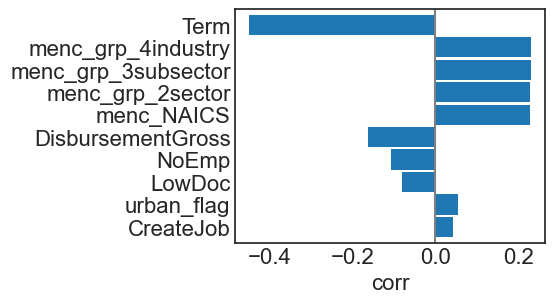

In [22]:
feat_corr(cor_df, 'target', outpath = Path(setup.temp_path))

The target feature is highly correlated with term (in Kaggle notebooks, models have very high performance, and I also see very high performance with this feature).  I think this feature is likely set by the creditworthiness of the businesses, as it is such a strong predictor

After term, NAICS seems to be the most significant feature.  Let's look at the NAICS feature now

##### NAICS correlations
NAICS mean encoding vs. non-NAICS features

In [23]:
feat_list = [c for c in cor_df.index if not 'menc_grp' in c]

,index,corr,corr_abs
6,DisbursementGross,-0.263009,0.263009
0,Term,-0.235051,0.235051
1,target,0.229250,0.229250
3,NoEmp,-0.136444,0.136444
4,CreateJob,0.081344,0.081344
5,LowDoc,-0.081071,0.081071
8,urban_flag,0.052259,0.052259
9,franchise_flag,0.043609,0.043609
7,new_business,0.035152,0.035152


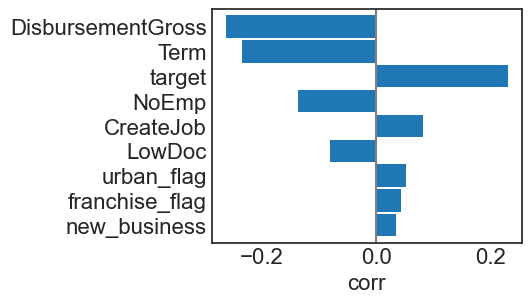

In [24]:
feat_corr(cor_df[cor_df.index.isin(feat_list)], 
                 'menc_NAICS', outpath = Path(setup.temp_path))

There are strong correlations with RevLineCr, RetainedJob, and other features. 

## Term
This feature is highly predictive and its use makes an excellent model.  I will probably drop it as it's probably set in proportion to creditworthiness.  Using this feature would make sense if you want to evaluate how well SBA is assigning risk, or to predict defaults given known risk.  But here I omit it because it makes a model so good NAICS doesn't matter.  Also removing this feature means predicting risk without the (implicit) benefit of the credit-worthiness assigned by the SBA.

I am going to explore how term is related to the target a little

##### Quartile stats

In [25]:
train_df['term_cat'] = pd.qcut(train_df['Term'], q=4)

In [26]:
train_df.groupby('term_cat') \
    .agg({'Term': 'mean', 'LoanNr_ChkDgt':'count',
          'target':'mean'})

,Term,LoanNr_ChkDgt,target
term_cat,,,
"(-0.001, 60.0]",40.458039,138748,0.433044
"(60.0, 84.0]",81.193118,154905,0.116220
"(84.0, 120.0]",110.812550,58026,0.127460
"(120.0, 569.0]",237.008148,84441,0.044658


There is a steady decrease in risk as term increases.  I wonder if enough time has passed to evaluate very long loans

##### Value counts, describe

In [27]:
train_df['Term'].value_counts().head(10)

Term
84     121763
60      41689
120     34408
240     34147
300     17547
36      10460
180      9607
12       8320
48       7912
72       4667
Name: count, dtype: int64

5 or 7 year terms are common!

In [28]:
train_df['Term'].describe()

count    436120.000000
mean        102.343176
std          74.297505
min           0.000000
25%          60.000000
50%          84.000000
75%         120.000000
max         569.000000
Name: Term, dtype: float64

## NAICS
What is the variation of term rates within vs. between sectors?

In [29]:
importlib.reload(sg_plot)

<module 'sba_gnn.sba_gnn.sg_plot' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_plot.py'>

In [30]:
# Summarize target rates and counts by NAICS
naics_info = sg_plot.naics_variance_data(sba_loans)
naics_info = naics_info.merge(naics_desc.rename(columns={'NAICS07':'NAICS'}),
                             how='left', on='NAICS')
naics_info.to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_counts_rates.csv'), index=False)

In [31]:
naics_info.head(5)

,NAICS,target_naics,count_naics,NAICS_sector,count_cat,target_cat,NAICS_sector_desc,target_naics_sd,target_cat_sd,NAICS07_desc
0,445310,0.119330,6746,44-45,125289,0.22761,Retail Trade,0.003947,0.001185,"Beer stores, packaged"
1,447110,0.174977,6618,44-45,125289,0.22761,Retail Trade,0.004670,0.001185,Convenience food with gasoline stations
2,451110,0.183920,5883,44-45,125289,0.22761,Retail Trade,0.005051,0.001185,Athletic equipment and supply stores (includin...
3,453220,0.227118,5878,44-45,125289,0.22761,Retail Trade,0.005465,0.001185,Balloon shops
4,453998,0.313694,5652,44-45,125289,0.22761,Retail Trade,0.006172,0.001185,Art supply stores


In [32]:
# Join in NAICS code descriptions

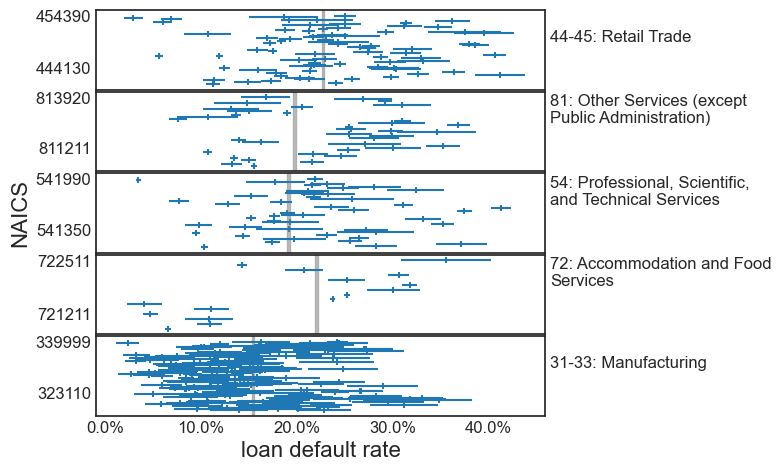

In [33]:
# Plot higher volume NAICS
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 100], num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates_100.png'),
           bbox_inches='tight')

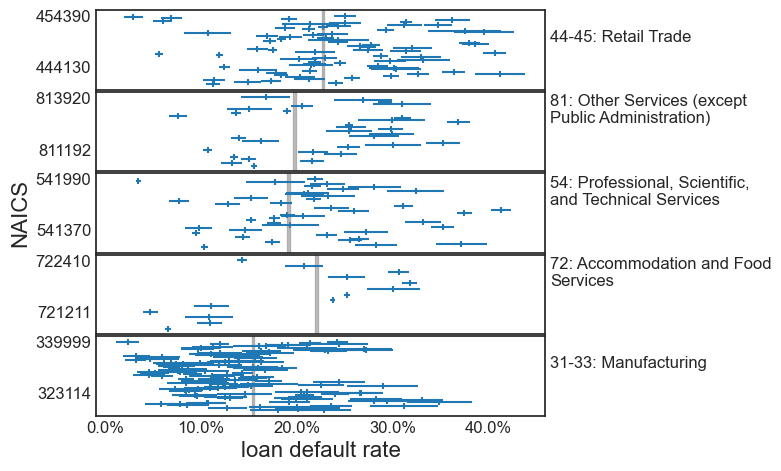

In [34]:
# Plot higher volume NAICS
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 150], num_sectors=5, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates_150.png'),
           bbox_inches='tight')

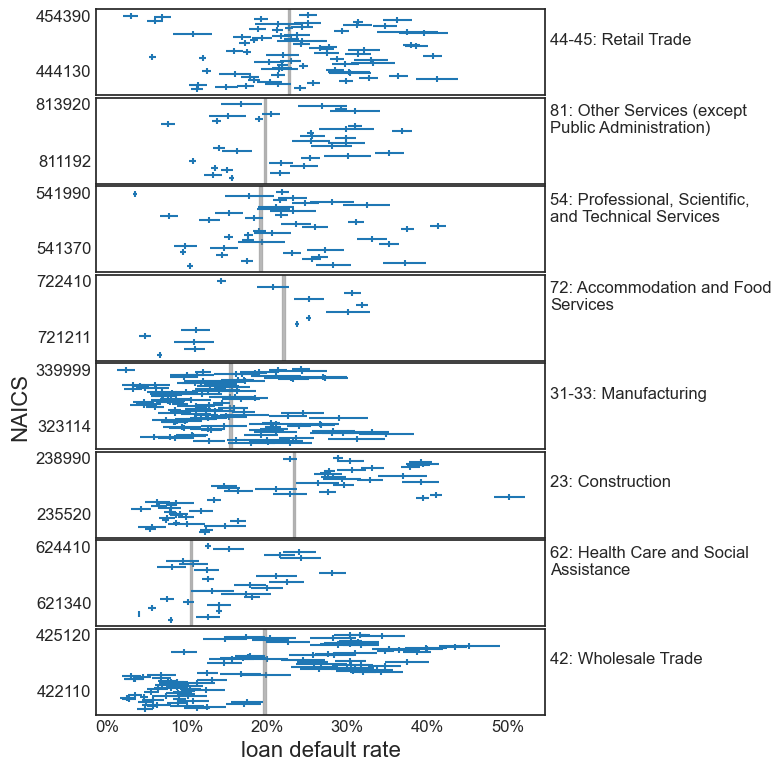

In [35]:
# Get top 8
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 150], num_sectors=8, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates_150_top8.png'),
           bbox_inches='tight')

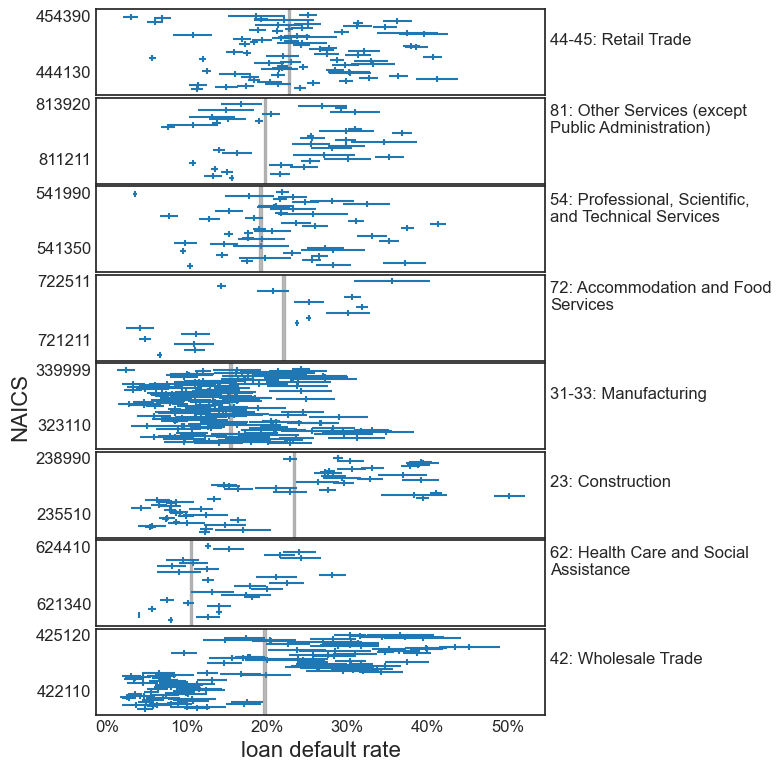

In [36]:
# Get top 8
plt.close()
fig = sg_plot.naics_variance_plot(naics_info[naics_info['count_naics'] >= 100], num_sectors=8, xlabel='loan default rate')
fig.savefig(Path(setup.temp_path).joinpath('02_PLOT_naics_counts_rates_100_top8.png'),
           bbox_inches='tight')

In [37]:
# Export high-volume data for analysis
naics_info[naics_info['count_naics'] >= 100] \
           .sort_values(['target_cat', 'target_naics'], ascending=[False, False]) \
           .to_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_counts_rates_high_vol.csv'), 
                   index=False)

## NAICS mean enodings
Examine where values differ - expect at low counts.  Focus on the training data

In [38]:
train_df =  sba_loans[sba_loans['dset'] == 'train'] 

In [39]:
train_naics_mean = train_df.groupby('NAICS')['target'].agg(['mean', 'count']) \
    .set_axis(['target', 'count'], axis=1) \
    .reset_index()

In [40]:
train_sector_mean = train_df.groupby('NAICS_sector')['target'].agg('mean') \
    .rename('sector_mean') \
    .reset_index()

In [42]:
naics_menc_info = train_df \
    .groupby('NAICS')[['NAICS_sector', 'menc_NAICS', 
                       'menc_grp_2sector', 'menc_grp_3subsector', 'menc_grp_4industry']].agg('first') \
    .reset_index() \
    .merge(train_naics_mean, on='NAICS') \
    .merge(train_sector_mean, on='NAICS_sector')

In [44]:
naics_menc_info['diff'] = naics_menc_info['menc_NAICS'] - naics_menc_info['menc_grp_2sector']
naics_menc_info['diff_abs'] = np.abs(naics_menc_info['diff'])

<Axes: xlabel='count', ylabel='diff_abs'>

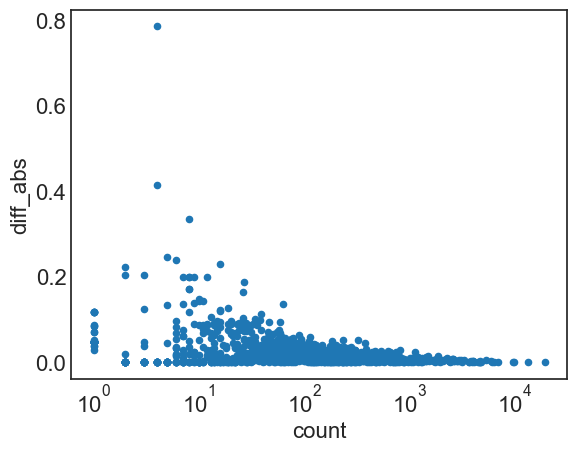

In [45]:
naics_menc_info.plot(x='count', y='diff_abs', kind='scatter',
                    logx=True)

In [46]:
naics_menc_info['quantile'] = pd.qcut(naics_menc_info['count'], q=10)

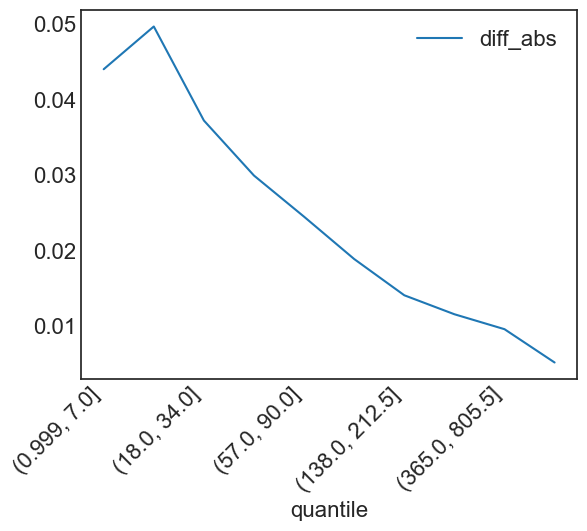

In [47]:
naics_menc_info.groupby('quantile')[['diff_abs']].agg('mean') \
    .plot()
_ = plt.xticks(rotation=45, ha='right')

In [48]:
naics_menc_info.sort_values('diff_abs', ascending=False).head(3)

,NAICS,NAICS_sector,menc_NAICS,menc_grp_2sector,menc_grp_3subsector,menc_grp_4industry,target,count,sector_mean,diff,diff_abs,quantile
12,111334,11,1.0,0.214705,0.189324,0.188406,0.50,4,0.087214,0.785295,0.785295,"(0.999, 7.0]"
873,522294,52,0.0,0.413747,0.354123,0.310987,0.50,4,0.275867,-0.413747,0.413747,"(0.999, 7.0]"
490,335228,31-33,0.0,0.334737,0.240807,0.309666,0.25,8,0.155853,-0.334737,0.334737,"(7.0, 18.0]"


In [49]:
naics_menc_info.sort_values('count', ascending=False).head(5)

,NAICS,NAICS_sector,menc_NAICS,menc_grp_2sector,menc_grp_3subsector,menc_grp_4industry,target,count,sector_mean,diff,diff_abs,quantile
1088,722110,72,0.235724,0.235278,0.235575,0.236395,0.236382,19570,0.218456,0.000446,0.000446,"(805.5, 19570.0]"
1089,722211,72,0.251807,0.251432,0.252495,0.251483,0.251133,13682,0.218456,0.000375,0.000375,"(805.5, 19570.0]"
1099,811111,81,0.153237,0.153659,0.152119,0.150634,0.151928,9985,0.201483,-0.000422,0.000422,"(805.5, 19570.0]"
1029,621210,62,0.040890,0.041842,0.040445,0.040822,0.040818,9677,0.100917,-0.000952,0.000952,"(805.5, 19570.0]"
1059,624410,62,0.128397,0.126378,0.125719,0.125963,0.126003,6976,0.100917,0.002019,0.002019,"(805.5, 19570.0]"


In [50]:
train_df['target'].mean()

0.2046546821975603

In [51]:
naics_menc_info['tdiff_menc'] = np.abs(naics_menc_info['target'] - naics_menc_info['menc_NAICS'])
naics_menc_info['tdiff_menc_grp'] = np.abs(naics_menc_info['target'] - naics_menc_info['menc_grp_2sector'])

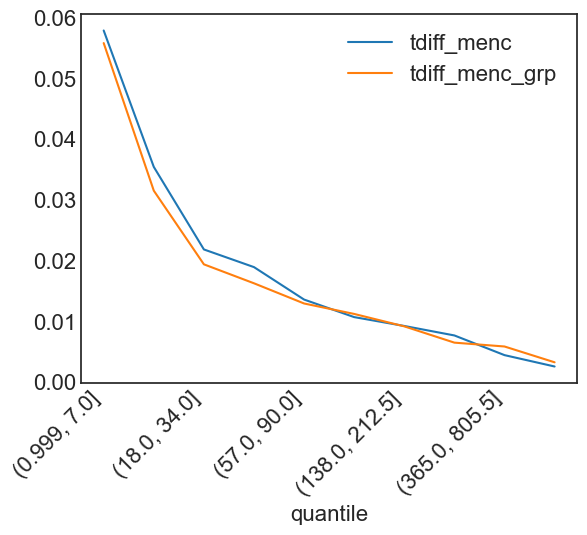

In [52]:
naics_menc_info.groupby('quantile')  \
    [['tdiff_menc', 'tdiff_menc_grp']] \
    .agg('median') \
    .plot()
_ = plt.xticks(rotation=45, ha='right')

In [54]:
train_df[['menc_NAICS', 'menc_grp_2sector', 'target', 'cenc_NAICS']].corr(method='spearman')

,menc_NAICS,menc_grp_2sector,target,cenc_NAICS
menc_NAICS,1.000000,0.991263,0.229250,-0.003067
menc_grp_2sector,0.991263,1.000000,0.229609,-0.002963
target,0.229250,0.229609,1.000000,-0.005516
cenc_NAICS,-0.003067,-0.002963,-0.005516,1.000000


In [56]:
sba_loans[sba_loans['dset'] != 'train'] [['menc_NAICS', 'menc_grp_2sector', 'target', 'cenc_NAICS']].corr()

,menc_NAICS,menc_grp_2sector,target,cenc_NAICS
menc_NAICS,1.000000,0.973224,0.200714,-0.019570
menc_grp_2sector,0.973224,1.000000,0.200709,-0.010671
target,0.200714,0.200709,1.000000,0.007075
cenc_NAICS,-0.019570,-0.010671,0.007075,1.000000


## Holdout NAICS

In [57]:
holdout_sum_01 = sba_loans.groupby(['dset', 'dset_naics_holdout']) \
    .agg({'LoanNr_ChkDgt':'count', 'NAICS_sector':pd.Series.nunique, 'NAICS':pd.Series.nunique}) \
    .reset_index() 

In [58]:
holdout_sum_02 = sba_loans.groupby(['dset', 'dset_naics_holdout', 'NAICS']) \
    ['LoanNr_ChkDgt'] \
    .agg('count') \
    .groupby(['dset', 'dset_naics_holdout']) \
    .agg(['mean', 'median', 'min', 'max']) 
holdout_sum_02.columns = ['loans_naics_' + c for c in holdout_sum_02.columns]
holdout_sum_02.reset_index(inplace=True)

In [59]:
holdout_stats = holdout_sum_01.merge(holdout_sum_02, on=['dset', 'dset_naics_holdout'])
holdout_stats.to_csv(Path(setup.temp_path).joinpath('02_REPORT_holdout_naics.csv'), index=False)
holdout_stats

,dset,dset_naics_holdout,LoanNr_ChkDgt,NAICS_sector,NAICS,loans_naics_mean,loans_naics_median,loans_naics_min,loans_naics_max
0,test,0,93455,20,1087,85.975161,23.0,1,4211
1,test,1,65052,18,131,496.580153,102.0,1,6104
2,train,0,436120,20,1166,374.030875,90.0,1,19570
3,val,0,93454,20,1100,84.958182,21.0,1,4160
